# Functions required for evolving a TLS with a PDM positioned in a field enhanced by a spherical nanoparticle

### Importing required libraries

In [1]:
from scipy import special as sp
from scipy.optimize import fsolve
import numpy as np
import matplotlib.pyplot as plt
import miepython
import pandas as pd
import csv
import qutip as qp
from scipy.integrate import solve_ivp

### Importing wavelengths and refractive indices

In [2]:
def import_data(filename): # filename must contain quotations and format!
    
    """ Imports wavelength and index of refraction data from a csv file with name FILENAME containing three columns
        storing wavelengths, real and complex components of the refractive index, respectively. """
    
    df = pd.read_csv(filename, sep = ',')

    # Read values of wavelength and index of refraction

    ref_lam = df.iloc[0:,0]
    ref_n = df.iloc[0:,1]   # real index of refraction
    ref_k = df.iloc[0:,2]   # complex index of refraction

    # Convert data into arrays

    ref_lam = ref_lam.to_numpy()
    ref_n = ref_n.to_numpy()
    ref_k = ref_k.to_numpy()
    
    return ref_lam, ref_n, ref_k

### Preliminary: Bessel and Hankel functions

In [3]:
def psi(x, order = 1): 
    
    """ Ricatti-Bessel spherical function of the first kind. """
    
    psi = np.sqrt(np.pi*x/2) * sp.jv(order + 1/2,x)
    return psi

def c(x, order = 1, second_kind = False):
    
    """ Spherical Hankel function of the first/second kind. """
    
    if second_kind:
        return np.sqrt(np.pi*x/2) * (sp.jv(order + 1/2,x) - 1j*sp.yv(order + 1/2,x))
    return np.sqrt(np.pi*x/2) * (sp.jv(order + 1/2,x) + 1j*sp.yv(order + 1/2,x)) 

def psi_prime(x, order = 1):

    """ First order derivative of Ricatti-Bessel spherical functions of the first kind. """
    
    psi_prime = np.sqrt(np.pi*x/2) * (sp.jv(order-1/2, x) - (order/x) * sp.jv(order + 1/2, x))
    
    return psi_prime

def c_prime(x, order = 1, second_kind = False):
    
    """ First order derivative of Ricatti-Bessel spherical functions of the first/second kind. """

    if second_kind:
        c_prime = np.sqrt(np.pi*x/2) * (sp.jv(order - 1/2,x) - 1j*sp.yv(order - 1/2,x) - \
                  (order/x) * (sp.jv(order + 1/2,x) - 1j*sp.yv(order + 1/2,x)))
    else:
        c_prime = np.sqrt(np.pi*x/2) * (sp.jv(order - 1/2,x) + 1j*sp.yv(order - 1/2,x) - \
                  (order/x) * (sp.jv(order + 1/2,x) + 1j*sp.yv(order + 1/2,x)))
    return c_prime


### First-order Mie scattering coefficients (Two different sources)

In [4]:
def wavenumber(lam, n = 1):
    
    """ Calculates wave number for wavelength LAM in a medium of refractive index N. Default 
        medium is vacuum. """
    
    k = 2 * np.pi * n / lam  
    
    return k

In [5]:
def a_1_b_1_lists(ref_ind, lam_list, r, n = 1, order = 1, YSK = True, Thovsen = False):   
    
    """ Outputs lists of a1 and b1 Mie scattering coefficients as defined in YSK/Thovsen paper for
        some input lists of wavelengths and corresponding refractive indices.
    
        Inputs:  ref_ind [float]: list of refractive indices for corresponding wavelengths LAM_LIST. 
                 REF_IND must be of the form real(ref_ind) + 1j*imag(ref_ind) [unitless]  
                 lam_list [float]: wavelengths corresponding to REF_IND [units of choice]
                 r [float]: radius of particle [units of choice]
                 n [float]: index of refraction of surrounding medium; vacuum by default [dimensionless] 
                 order [int]: order at which the Bessel function expansions are terminated
                 YSK [bool]: if True, equations from the YSK paper are used 
                 Thovsen [bool]: if True, equations from the Thovsen paper are used 
                 NOTE: the two implementations should produce the same results BUT YSK coefficients
                 are exchanged in the paper i.1. A1 is B1 and B1 is A1
        Outputs: A_1 [float]: array of 'a1' Mie coefficients corresponding to LAM_LIST and REF_IND
                 B_1 [float]: array of 'b1' Mie coefficients corresponding to LAM_LIST and REF_IND """
        
    k = wavenumber(lam_list, n)   
    rho1 = k * r
    rho2 = ref_ind * k * r
    eps1 = n**2
    eps2 = ref_ind**2
    j_rho1 = sp.spherical_jn(n = order, z = rho1, derivative=False)
    j_rho2 = sp.spherical_jn(n = order, z = rho2, derivative=False)
    y_rho1 = sp.spherical_yn(n = order, z = rho1, derivative=False)
    y_rho2 = sp.spherical_yn(n = order, z = rho2, derivative=False)
    j_prime_rho1 = sp.spherical_jn(n = order, z = rho1, derivative = True)
    j_prime_rho2 = sp.spherical_jn(n = order, z = rho2, derivative = True)
    y_prime_rho1 = sp.spherical_yn(n = order, z = rho1, derivative = True)
    y_prime_rho2 = sp.spherical_yn(n = order, z = rho2, derivative = True)

    h1_rho1 = j_rho1 + 1j*y_rho1
    h1_rho2 = j_rho2 + 1j*y_rho2
    h1_prime_rho1 = j_prime_rho1 + 1j*y_prime_rho1
    h1_prime_rho2 = j_prime_rho2 + 1j*y_prime_rho2
    
    psi_rho1 = rho1*j_rho1
    psi_rho2 = rho2*j_rho2
    psi_prime_rho1 = rho1*j_prime_rho1 + j_rho1
    psi_prime_rho2 = rho2*j_prime_rho2 + j_rho2
            
    xi_rho1 = rho1*h1_rho1
    xi_rho2 = rho2*h1_rho2
    xi_prime_rho1 = rho1*h1_prime_rho1 + h1_rho1
    xi_prime_rho2 = rho2*h1_prime_rho2 + h1_rho2

    h2_rho1 = j_rho1 - 1j*y_rho1 # spherical Hankel function of the second kind
    h2_prime_rho1 = j_prime_rho1 - 1j*y_prime_rho1 # derivative of spherical Hankel function of the second kind
    xi_rho1_sk = rho1*h2_rho1 
    xi_pr_rho1_sk = rho1*h2_prime_rho1 + h2_rho1 
    
    if YSK:
        # A and B exchanged to comply with Thovsen conventions for Mie expansions
        numerator_B = j_rho1*psi_prime_rho2 - j_rho2*psi_prime_rho1
        denominator_B = j_rho2*xi_prime_rho1 - h1_rho1*psi_prime_rho2
        numerator_A = eps1*j_rho1*psi_prime_rho2 - eps2*j_rho2*psi_prime_rho1
        denominator_A = eps2*j_rho2*xi_prime_rho1 - eps1*h1_rho1*psi_prime_rho2

    if Thovsen:
        numerator_A = psi_prime_rho2 * psi_rho1 - ref_ind * psi_rho2 * psi_prime_rho1
        denominator_A = psi_prime_rho2 * xi_rho1_sk - ref_ind * psi_rho2 * xi_pr_rho1_sk
        numerator_B = ref_ind * psi_prime_rho2 * psi_rho1 - psi_rho2 * psi_prime_rho1
        denominator_B = ref_ind * psi_prime_rho2 * xi_rho1_sk - psi_rho2 * xi_pr_rho1_sk
        
    A_1 = numerator_A / denominator_A
    B_1 = numerator_B / denominator_B
    return A_1, B_1

### Evaluating scattering and extinction cross sections

In [6]:
def sca_cross_section_analytical(a_1, b_1, ref_lam):
    
    """ Calculates scattering cross section for a zeroth order Mie approximation with coefficients A_1 and B_1. 
    
        Inputs:  a_1, b_1 [float]: array of 'a1' and 'b1' Mie coefficients 
                 ref_lam [float]: array of wavelengths corresponding to 'a1' and 'b1'
        Outputs: qsca [float]: array of scattering cross section values for all REF_LAM """
        
    mod_a_1 = np.abs(a_1)
    mod_b_1 = np.abs(b_1)
    
    qsca = 3 * (ref_lam**2) * (mod_a_1**2 + mod_b_1**2) / (2*np.pi)
    
    return qsca

def ext_cross_section_analytical(a_1, b_1, ref_lam):
    
    """ Calculates extinction cross section for a zeroth order Mie approximation with coefficients A_1 and B_1. 
    
        Inputs:  a_1, b_1 [float]: array of 'a1' and 'b1' Mie coefficients 
                 ref_lam [float]: array of wavelengths corresponding to 'a1' and 'b1'
        Outputs: qsca [float]: array of extinction cross section values for all REF_LAM """

    mod_a_1 = np.abs(a_1)
    mod_b_1 = np.abs(b_1)
    
    qext = 3 * (ref_lam**2) *  np.real(a_1 + b_1) / (2*np.pi)
    
    return qext

### Plotting cross sections

In [7]:
def plot_cross_section(lam_list, cross_section1, cross_section2 = [None,None], cross_section3 = [None,None], 
                       figtitle = 'Scattering Cross Section', label1 = 'full', label2 = 'electric + magnetic dipole',
                       label3 = 'electric dipole', xlim = [300,1000], color1 = 'k', color2 = 'purple', color3 = 'b',
                       savefig = False, savefigtitle = 'scattering_cross_section_plot.jpg'):
    
    """ Plots up to three cross sections on the same figure. Labels, title, colors of lines and wavelength limits 
    can be changed by user. If SAVEFIG is True, the function saves the plot in a pdf file with name SAVEFIGTITLE. """
    
    fig, ax = plt.subplots(1,1,figsize=(8, 5))

    ax.plot(lam_list * 1000, cross_section1, linestyle='-', marker = 'o', color = color1, label = label1)
    
    if cross_section2[0] != None:
        ax.plot(lam_list * 1000, cross_section2, linestyle='-', marker = 's', color = color2, label = label2) 
   
    if cross_section3[0] != None:
        ax.plot(lam_list * 1000, cross_section3, linestyle='-', marker = 'x', color = color3, label = label3) 

    ax.set_xlabel('Wavelength [nm]', fontsize = 10)
    ax.set_ylabel('Cross Section [µm²]', fontsize = 10)
    ax.set_title(figtitle, fontsize = 11)
    plt.xlim(xlim)
    ax.minorticks_on()
    ax.tick_params(axis="both", direction="in", which="both", right=True, top=True, labelsize=9)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.3)
    ax.grid(alpha = 0.2)
    ax.legend(fontsize=9)
    
    if savefig:
        plt.savefig(savefigtitle, format='jpg', bbox_inches="tight")

    return

### Finding electric field at different points around the nanosphere

In [8]:
# All functions incorporate only the electric dipole term into Mie scattering calculations. Polarisation is in 
# the x-direction, wave propagation in the z-direction.
# Spherical coordinates: rho, theta, phi, where rho is the radial unit vector rescaled by the wavenumber of the
# incident light. While the user can freely choose units in this section, the unit system should be consistent.

def max_a_1(refr_ind, lam_list, r, n = 1):
    
    """ Finds a_1 coefficient from zeroth order Mie scattering theory that corresponds to the wavelength
        of maximum scattering.
    
        Inputs:  refr_ind [float]: list of refractive indices for corresponding wavelengths LAM_LIST. 
                 REFR_IND must be of the form real(refr_ind) + 1j*imag(refr_ind) [unitless]  
                 lam_list [float]: wavelengths corresponding to REFR_IND [units of choice]
                 r [float]: radius of particle [units of choice]
                 n [float]: index of refraction of surrounding medium; vacuum by default [dimensionless] 
                 
        Outputs: mod_a_1_max [float]: modulus of the a_1 scattering coefficient for given input parameters """
   
    a_1_array, b_1_array = a_1_b_1_lists(ref_ind = refr_ind, lam_list = lam_list, r = r, Thovsen = True)
    
    sca_cross_section_no_mag = sca_cross_section_analytical(a_1_array, 0, lam_list) # no magnetic terms
    max_sca = sca_cross_section_no_mag.max()
    index = np.where(sca_cross_section_no_mag == max_sca)
    a_1_max = a_1_array[index]
    mod_a_1_max = np.abs(a_1_max)
    
    return mod_a_1_max

def max_lam(refr_ind, lam_list, r, n = 1):
    
    """ Finds wavelength from input list for which the scattering cross-section of the nanoparticle is maximised. 
    
        Inputs:  refr_ind [float]: list of refractive indices for corresponding wavelengths LAM_LIST. 
                 REFR_IND must be of the form real(refr_ind) + 1j*imag(refr_ind) [unitless]  
                 lam_list [float]: wavelengths corresponding to REFR_IND [units of choice]
                 r [float]: radius of particle [units of choice]
                 n [float]: index of refraction of surrounding medium; vacuum by default [dimensionless] 
                 
        Outputs: lam_max [float]: wavelength of maximum scattering for given inputs [units determined by input]"""
  
    a_1_array, b_1_array = a_1_b_1_lists(ref_ind = refr_ind, lam_list = lam_list, r = r, Thovsen = True)
    
    sca_cross_section_no_mag = sca_cross_section_analytical(a_1_array, 0, lam_list)
    max_sca = sca_cross_section_no_mag.max()
    index = np.where(sca_cross_section_no_mag == max_sca)
    lam_max = lam_list[index]
    
    return lam_max 

def spherical_coords(x, y, z, lam_max, n = 1): 
    
    """ Transforms Cartesian coordinates into spherical coordinates for Mie scattering calculations.
    
        Inputs:  x,y,z [float]: input Cartesian coordinates [units of choice]
                 lam_max [float]: incident wavelength [units of choice]. For best results, LAM_MAX should be 
                 near the maximum of the scattering cross-section 
                 n [float]: index of refraction of surrounding medium; vacuum by default [dimensionless]
                 
        Outputs: rho, theta, phi [float]: radial, polar and azimuthal coordinates corresponding to (X,Y,Z) """
        
    k = wavenumber(lam_max, n)  
    radius_coord = np.sqrt(x**2 + y**2 + z**2)
    
    rho = k*radius_coord      
    theta = np.arctan(np.sqrt(x**2 + y**2)/z)
    phi = np.arctan(y/x)
    
    return rho, theta, phi

def E_radial(x, y, z, lam_max, a_1_max, n = 1): 
    
    """ Calculates normalised radial component (E_r / E_0) of scattered field in spherical coordinates.
    
        Inputs:  x,y,z [float]: input Cartesian coordinates [units of choice]  
                 lam_max [float]: incident wavelength [units of choice]. For best results, LAM_MAX should be 
                 near the maximum of the scattering cross-section
                 a_1_max [float]: a_1 coefficient for incident LAM_MAX [dimensionless]
                 n [float]: index of refraction of surrounding medium; vacuum by default [dimensionless]
                 
        Ouputs:  E_r [float]: radial component of the field enhancement """
    
    rho, theta, phi = spherical_coords(x, y, z, lam_max, n)
    E_r = 3 * a_1_max * np.sqrt(np.pi/(2*rho)) * (sp.jv(3/2,rho) + 1j * sp.yv(3/2,rho)) * np.cos(phi) * np.sin(theta) / rho
    
    return E_r 

def E_theta(x, y, z, lam_max, a_1_max, n = 1): 
    
    """ Calculates normalised theta component (E_theta / E_0) of scattered field in spherical coordinates.
    
        Inputs:  x,y,z [float]: input Cartesian coordinates [units of choice]
                 lam_max [float]: incident wavelength [units of choice]. For best results, LAM_MAX should be 
                 near the maximum of the scattering cross-section
                 a_1_max [float]: a_1 coefficient for incident LAM_MAX [dimensionless]
                 n [float]: index of refraction of surrounding medium; vacuum by default [dimensionless]
                 
        Ouputs:  E_theta [float]: polar component of the field enhancement  """
    
    rho, theta, phi = spherical_coords(x, y, z, lam_max, n)
    
    hankel1_2 = sp.jv(1/2, rho) + 1j*sp.jv(1/2, rho)
    hankel3_2 = sp.jv(3/2, rho) + 1j*sp.jv(3/2, rho)

    E_theta = (3/2) * a_1_max * np.sqrt(np.pi/(2*rho)) * np.cos(phi) * np.cos(theta) * (hankel1_2 - hankel3_2/rho)
    
    return E_theta

def E_phi(x, y, z, lam_max, a_1_max, n = 1):  
    
    """ Calculates normaised phi component (E_phi / E_0) of scattered field in spherical coordinates.
    
        Inputs:  x,y,z [float]: input Cartesian coordinates [units of choice]  
                 lam_max [float]: incident wavelength [units of choice]. For best results, LAM_MAX should be 
                 near the maximum of the scattering cross-section
                 a_1_max [float]: a_1 coefficient for incident LAM_MAX [dimensionless]
                 n [float]: index of refraction of surrounding medium; vacuum by default [dimensionless]
                 
        Ouputs:  E_phi [float]: azimuthal component of the field enhancement """

    rho, theta, phi = spherical_coords(x, y, z, lam_max, n)
    
    hankel1_2 = sp.jv(1/2, rho) + 1j*sp.jv(1/2, rho)
    hankel3_2 = sp.jv(3/2, rho) + 1j*sp.jv(3/2, rho)
    
    E_phi = (-3/2) * a_1_max * np.sqrt(np.pi/(2*rho)) * np.sin(phi) * (hankel1_2 - hankel3_2/rho)
    
    return E_phi

# Input Cartesian coordinates, output components of scattered field in spherical coordinates

def scattered_field_spherical(x, y, z, refr_ind, lam_max, r, a_1_max, n = 1): 
    
    """ Outputs the three components of the field enhancement by a spherical nanoparticle in spherical coordinates.
    
        Inputs:  x,y,z [float]: input Cartesian coordinates [units of choice]
                 refr_ind [float]: SINGLE refractive index corresponding to wavelength LAM_MAX. 
                 Must be of the form real(refr_ind) + 1j*imag(refr_ind) [unitless]  
                 lam_max [float]: incident wavelength [units of choice]. For best results, LAM_MAX should be 
                 near the maximum of the scattering cross-section
                 a_1_max [float]: a_1 coefficient for incident LAM_MAX [dimensionless]
                 n [float]: index of refraction of surrounding medium; vacuum by default [dimensionless]
                 
        Ouputs:  E_r, E_th, E_ph [float]: radial, polar and azimuthal components of the field enhancement """
    
    E_r = E_radial(x, y, z, lam_max, a_1_max, n)
    E_th = E_theta(x, y, z, lam_max, a_1_max, n)
    E_ph = E_phi(x, y, z, lam_max, a_1_max, n)
    
    return E_r, E_th, E_ph  

In [9]:
def scattered_field_cartesian(x, y, z, refr_ind, lam_list, r, lam_value = None, n = 1, 
                              absolute_value = True):
    
    """ Outputs complex/absolute values of the components of the field enhancement by a shperical nanoparticle of
        radius R at points (X,Y,Z) in Cartesian coordinates.
    
        Inputs:  x,y,z [float]: input Cartesian coordinates [units of choice]
                 refr_ind [float]: list of refractive indices for corresponding wavelengths LAM_LIST. 
                 REFR_IND must be of the form real(refr_ind) + 1j*imag(refr_ind) [unitless]  
                 lam_list [float]: wavelengths corresponding to REFR_IND [units of choice]
                 r [float]: radius of particle [units of choice]
                 lam_value [float]: wavelength of incident plane wave (must belong to LAM_LIST) [units of choice]
                 If omitted, the calculation is performed at the frequency of maximum scattering.
                 n [float]: index of refraction of surrounding medium; vacuum by default [dimensionless]
                 absolute_value [bool]: If true, the modulus of component enhancements is calculated
                 
        Outputs: E_x, E_y, E_z [float]: scattered field/field enhancement at points (X,Y,Z)"""

    if lam_value == None:
        # Find parameters at resonance
        a_1_max = max_a_1(refr_ind, lam_list, r, n = 1)
        lam_max = max_lam(refr_ind, lam_list, r, n = 1)
    else:
        index = np.where(lam_list == lam_value)
        m_value = refr_ind[index]
        a_1_max, b_1_max = a_1_b_1_lists(ref_ind = m_value, lam_list = lam_value, r = r, Thovsen = True)  
        lam_max = lam_value

    E_r, E_th, E_ph = scattered_field_spherical(x, y, z, refr_ind, lam_max, r, a_1_max, n)
    
    rho, theta, phi = spherical_coords(x, y, z, lam_max, n)
    
    E_x = E_r * np.sin(theta) * np.cos(phi) + E_th * np.cos(theta) * np.cos(phi) - E_ph * np.sin(phi)
    E_y = E_r * np.sin(theta) * np.sin(phi) + E_th * np.cos(theta) * np.sin(phi) + E_ph * np.cos(phi)
    E_z = 1 + E_r * np.cos(theta) - E_th * np.sin(theta)
    
    if absolute_value:
        E_x = np.abs(E_x)
        E_y, = np.abs(E_y)
        E_z = np.abs(E_z)
    
    return E_x, E_y, E_z

def scattered_field_absolute(x, y, z, refr_ind, lam_list, r, lam_value = None, n = 1):
    
    """ Calculates the absolute value of the field enhancement by a spherical nanoparticle for input points (x,y,z).
        
        Inputs:  x,y,z [float]: input Cartesian coordinates [units of choice]
                 refr_ind [float]: list of refractive indices for corresponding wavelengths LAM_LIST. 
                 REFR_IND must be of the form real(refr_ind) + 1j*imag(refr_ind) [unitless]  
                 lam_list [float]: wavelengths corresponding to REFR_IND [units of choice]
                 r [float]: radius of particle [units of choice]
                 lam_value [float]: wavelength of incident plane wave (must belong to LAM_LIST) [units of choice]
                 If omitted, the calculation is performed at the frequency of maximum scattering.
                 n [float]: index of refraction of surrounding medium; vacuum by default [dimensionless]
                 
        Outputs: E [float]: absolute value of field enhancement at (X,Y,Z) """

    E_x, E_y, E_z = scattered_field_cartesian(x, y, z, refr_ind, lam_list, r, lam_value, n, absolute_value = True)

    E = np.sqrt(E_x**2 + E_y**2 + E_z**2)
    
    return E

### Plotting the enhanced scattered field

In [147]:
def plot_scattered_field(x_points, y_points, z, refr_ind, lam_list, r, lam_value = 0.36, n = 1, \
                         filename = 'defaultFile.txt', figsize = [10,10], savefig = False): 
    
    """ Calculates of the field enhancement by a spherical nanoparticle of radius R along in the XY-plane for
        a cross section of the nanosphere at height Z. The function outputs a txt file with field values for
        coordinates (X_POINTS, Y_POINTS) and a colorbar plot of the field enhancement.
        
        Inputs:  x_points [float]: array of x coordinates at which the field is evaluated [nm]
                 y_points [float]: array of y coordinates at which the field is evaluated [nm]
                 z [float]: fixed coordinate that defines the plane of cross section [nm]
                 refr_ind [float]: list of refractive indices for corresponding wavelengths LAM_LIST. 
                 REFR_IND must be of the form real(refr_ind) + 1j*imag(refr_ind) [unitless]                 
                 lam_list [float]: wavelengths corresponding to REFR_IND [μm] 
                 r [float]: radius of particle [μm]
                 lam_value [float]: wavelength of incident plane wave (must belong to LAM_LIST) [m]
                 If omitted, the calculation is performed at the frequency of maximum scattering.
                 n [float]: index of refraction of surrounding medium; vacuum by default [dimensionless]
                 filename [string]: name for txt file with coordinates and field values
                 figsize [float]: x and y dimensions of the colorbar plot
                 savefig [bool]: If True, figure saved under the name 'scattered_field_plot.jpg'
    
        Outputs: wavelength [string]: print message detailing wavelength of the incident field
                 E_max [string]: print message detailing the maximum field enhancement for the given 
                 input parameters """
    
    # Rescale coordinates to meters
    x_vals = x_points * 1.0e-9
    y_vals = y_points * 1.0e-9
    z_val = z * 1.0e-9

    if lam_value != None:
        if lam_value not in lam_list:
            print("Refractive index for this wavelength is not known. Please, choose wavelength from the input list of wavelengths.")
    
    # Rescale input parameters to meters
    lam_vals = lam_list * 1.0e-6
    lam_val = lam_value * 1.0e-6
    rad = r * 1.0e-6
    
    # Create txt file with coordinate values
    f = open(filename,'w')
    f.write("# X [nm] , Y [nm], E/E_0 \n")
    coord = []
    
    # Build arrays of points and scattered fields
    colors = np.array([])
    points_x = []
    points_y = []
    
    for j in y_vals:
        for i in x_vals:
            if i**2 + j**2 < rad**2:
                E = [0]
            else:
                E = scattered_field_absolute(i, j, z_val, refr_ind, lam_vals, rad, lam_val, n) # in V/m
            points_x.append(1.0e9*i) # rescale to nm for plot
            points_y.append(1.0e9*j) # rescale to nm for plot
            colors = np.append(colors, E)
            
            c = [1e9*i , 1e9*j , *E]  # coordinates for txt file
            coord.append(c)
            
    # Plot
    fig, ax = plt.subplots(1,1, figsize = (figsize[0], figsize[1]))
    plt.scatter(points_y, points_x, c=colors, cmap='jet')
    plt.xlabel('X [nm]')
    plt.ylabel('Y [nm]')
    plt.title('Field enhancement in X-Y plane')

    cbar = plt.colorbar(shrink = 0.6)
    cbar.ax.set_title(r'$|E|/|E_0|$')

    ax.set_aspect('equal')

    plt.show()
    if savefig:
        plt.savefig('scattered_field_plot.jpg', format='jpg', bbox_inches='tight')
    
    # Write the coordinates in the txt file
    csv.writer(f, delimiter=',').writerows(coord)
    f.close()
    
    # Return values
    if lam_value == None:
        wavelength = f'At incoming wavelength of {1e3 * max_lam(refr_ind, lam_list, r)} nm'
    else:
        wavelength = f'At incoming wavelength of {1e3 * lam_value} nm'
    E_max = f'Maximum scattered field = {colors.max()} E_0'
    
    return wavelength, E_max

### Plotting different cross-sections of the scattered field

In [11]:
def scattered_field_components(x_points, y_points, z, refr_ind, lam_list, r, lam_value = None, n = 1,
                                   E_0 = None, plot = True, savefig = False):
    
    """ Plots the three cartesian components of the field scattered by a spherical nanoparticle of radius R
        according to a zeroth order Mie theory approximation for an array of positions (X_POINTS, Y_POINTS)
    
        Inputs:  x_points [float]: array of x coordinates at which the field is evaluated [nm]
                 y_points [float]: array of y coordinates at which the field is evaluated [nm]
                 z [float]: fixed coordinate that defines the plane of cross section [nm]
                 refr_ind [float]: list of refractive indices for corresponding wavelengths LAM_LIST. 
                 REFR_IND must be of the form real(refr_ind) + 1j*imag(refr_ind) [unitless]                 
                 lam_list [float]: wavelengths corresponding to REFR_IND [micrometers] 
                 r [float]: radius of particle [μm]
                 lam_value [float]: wavelength of incident plane wave (must belong to LAM_LIST) [m]
                 If omitted, the calculation is performed at the frequency of maximum scattering.
                 n [float]: index of refraction of surrounding medium; vacuum by default [dimensionless]
                 E_0 [float]: amplitude of the incident electric field [au]. If omitted, the code outputs the 
                 enhancement of the field by the nanoparticle (same for all E_0 values)
                 plot [bool]: if True, output includes plot of the three components 
                 savefig [bool]: If True, figure saved under the name 'field_components_plot.jpg'
                 
        Outputs: E_x_values, E_y_values, E_z_values [float]: arrays of x,y and z components of the scattered 
                 field [V/m] """
    
    # Rescale coordinates to meters
    x_points = x_points * 1.0e-9
    y_points = y_points * 1.0e-9
    z = z * 1.0e-9

    if lam_value != None:
        if lam_value not in lam_list:
            print("Refractive index for this wavelength is not known. Please, choose wavelength from the input list.")
        index = np.where(lam_list == lam_value)
        m_value = refr_ind[index]
    else:
        # Find parameters at resonance
        lam_max = max_lam(refr_ind, lam_list, r, n = 1)
        lam_value = lam_max
        index = np.where(lam_list == lam_max)
        m_value = refr_ind[index]
    
    #Rescale input parameters to meters
    lam_list = lam_list * 1.0e-6
    lam_value = lam_value * 1.0e-6
    r = r * 1.0e-6
    
    # Build arrays of points and scattered fields
    E_x_values = np.array([])
    E_y_values = np.array([])
    E_z_values = np.array([])    
    points_x = []
    points_y = []
    
    for j in y_points:
        for i in x_points:
            if i**2 + j**2 < r**2:
                E_x = [0]
                E_y = [0]
                E_z = [0]
            
            else:
                E_x, E_y, E_z = scattered_field_cartesian(i, j, z, refr_ind, lam_list, r, lam_value, n,
                                                          absolute_value = True)
                
            points_x.append(1e9*i) # rescale to nm for plot
            points_y.append(1e9*j) # rescale to nm for plot
            
            E_x_values = np.append(E_x_values, E_x)
            E_y_values = np.append(E_y_values, E_y)
            E_z_values = np.append(E_z_values, E_z)
            
    if plot:
        # Plot    
        fig, ax = plt.subplots(1, 3, figsize = (16,5))    

        ax[0].scatter(points_y, points_x, c=E_x_values, cmap='jet')
        ax[0].set_title('Scattered Field in X Direction')

        ax[1].scatter(points_y, points_x, c=E_y_values, cmap='jet')
        ax[1].set_title('Scattered Field in Y Direction')

        ax[2].scatter(points_y, points_x, c=E_z_values, cmap='jet')
        ax[2].set_title('Scattered Field in Z Direction')
    
        for i in range(3):
            ax[i].set_xlabel('X [nm]')
            ax[i].set_ylabel('Y [nm]')
            ax[i].set_aspect('equal')
        
        fig.suptitle('Components of Scattered Field', y = 1.06, fontsize = 'xx-large', fontweight='bold')
        plt.show()
        if savefig:
            plt.savefig('field_components_plot.jpg', format='jpg', bbox_inches='tight')

    # Remove normalisation
    if E_0 != None:
        E_x_values = E_x_values * E_0        
        E_y_values = E_y_values * E_0
        E_z_values = E_z_values * E_0

    return E_x_values, E_y_values, E_z_values

### Calculating decay rates

In [12]:
def gamma_factors(d_points, ref_ind, lam_val, r, n = 1, order = 1, plot = False, savefig = False, lim = True):   
    
    """ Calculates total and radiative decay rates for both vertical and horizontal orientations of the TLS as
        defined by the YSK paper. 
 
        Inputs:  d_points [float]: distances from centre of nanosphere at which decay rates are evaluated [m]
                 ref_ind [float]: SINGLE refractive index value corresponding to LAM_VAL [dimensionless] 
                 Must be of the form real(ref_ind) + 1j*imag(ref_ind)
                 lam_val [float]: wavelength of incident plane wave [m]
                 r [float]: radius of the nanosphere [m]
                 n [float]: index of refraction of surrounding medium; vacuum by default [dimensionless]
                 order [int]: order at which the Bessel function expansions of the Mie coefficients is terminated
                 plot [bool]: if True, plot of gamma as a function of distance from surface of nanoparticle
                              in units of r is produced 
                 savefig [bool]: if True, figure saved under the name 'decay_rates.jpg'
                 lim [bool]: if True, y axis of plot limited to [0,2] as in Figure 1 in the Kim et al paper
                 
        Outputs: A_list [float]: list of 'a' Mie coefficients for the given positions
                 B_list [float]: list of 'b' Mie coefficients for the given positions
                 gamma_norm_vals [float]: array of normal total decay rates for the given positions
                 gamma_tang_vals [float]: array of tangential total decay rates for the given positions
                 gamma_norm_rad_vals [float]: array of normal radiative decay rates for the given positions
                 gamma_tang_rad_vals [float]: array of tangential radiative decay rates for the given positions """

    eps1 = n**2
    eps2 = ref_ind**2
    k1 = 2 * np.sqrt(eps1) * np.pi / lam_val # surrounding medium (vacuum)
    k2 = 2 * ref_ind * np.pi / lam_val# nanoparticle
    rho1 = k1*r
    rho2 = k2*r
    
    gamma_norm_vals = np.zeros_like(d_points, dtype = float)
    gamma_tang_vals = np.zeros_like(d_points, dtype = float)
    gamma_norm_rad_vals = np.zeros_like(d_points, dtype = float)
    gamma_tang_rad_vals = np.zeros_like(d_points, dtype = float)
    
    A_list = np.zeros((order,len(d_points)), dtype = complex)
    B_list = np.zeros((order,len(d_points)), dtype = complex)

    j = 0
    for d in d_points:
        #dis = r + d
        y1 = k1*d 

        gamma_norm_sum = 0.0
        gamma_tang_sum = 0.0
        gamma_norm_rad_sum = 0.0
        gamma_tang_rad_sum = 0.0
        for i in range(1,order+1):
            j_rho1 = sp.spherical_jn(n = i, z = rho1, derivative = False)
            j_rho2 = sp.spherical_jn(n = i, z = rho2, derivative = False)
            y_rho1 = sp.spherical_yn(n = i, z = rho1, derivative = False)
            y_rho2 = sp.spherical_yn(n = i, z = rho2, derivative = False)
            h1_rho1 = j_rho1 + 1j*y_rho1
            h1_rho2 = j_rho2 + 1j*y_rho2
            
            j_prime_rho1 = sp.spherical_jn(n = i, z = rho1, derivative = True)
            j_prime_rho2 = sp.spherical_jn(n = i, z = rho2, derivative = True)
            y_prime_rho1 = sp.spherical_yn(n = i, z = rho1, derivative = True)
            y_prime_rho2 = sp.spherical_yn(n = i, z = rho2, derivative = True)
            h1_prime_rho1 = j_prime_rho1 + 1j*y_prime_rho1
            h1_prime_rho2 = j_prime_rho2 + 1j*y_prime_rho2
    
            psi_rho1 = rho1*j_rho1
            psi_rho2 = rho2*j_rho2
            psi_prime_rho1 = rho1*j_prime_rho1 + j_rho1
            psi_prime_rho2 = rho2*j_prime_rho2 + j_rho2
            
            xi_rho1 = rho1*h1_rho1
            xi_rho2 = rho2*h1_rho2
            xi_prime_rho1 = rho1*h1_prime_rho1 + h1_rho1
            xi_prime_rho2 = rho2*h1_prime_rho2 + h1_rho2

            j1_y1 = sp.spherical_jn(n = i, z = y1, derivative = False)
            y1_y1 = sp.spherical_yn(n = i, z = y1, derivative = False)
            h1_y1 = j1_y1 + 1j*y1_y1
            j_prime_y1 = sp.spherical_jn(n = i, z = y1, derivative = True)
            y_prime_y1 = sp.spherical_yn(n = i, z = y1, derivative = True)
            h1_prime_y1 = j_prime_y1 + 1j*y_prime_y1
        
            psi_y1 = y1*j1_y1
            psi_prime_y1 = y1*j_prime_y1 + j1_y1
            xi_y1 = y1*h1_y1
            xi_prime_y1 = y1*h1_prime_y1 + h1_y1

            numerator_A = j_rho1*psi_prime_rho2 - j_rho2*psi_prime_rho1
            denominator_A = j_rho2*xi_prime_rho1 - h1_rho1*psi_prime_rho2

            numerator_B = eps1*j_rho1*psi_prime_rho2 - eps2*j_rho2*psi_prime_rho1
            denominator_B = eps2*j_rho2*xi_prime_rho1 - eps1*h1_rho1*psi_prime_rho2
    
            A_i = numerator_A / denominator_A
            B_i = numerator_B / denominator_B

            A_list[i-1,j] = A_i
            B_list[i-1,j] = B_i

            g_norm_i = (2*i+1)*i*(i+1)*B_i*((h1_y1/y1)**2)
            gamma_norm_sum = gamma_norm_sum + g_norm_i
            g_norm_rad_i = i*(i+1)*(2*i+1)*((abs((j1_y1 + B_i*h1_y1)/y1))**2)
            gamma_norm_rad_sum = gamma_norm_rad_sum + g_norm_rad_i
    
            g_tang_i = (i+0.5)*(B_i*((xi_prime_y1/y1)**2) + A_i*((h1_y1)**2))
            gamma_tang_sum = gamma_tang_sum + g_tang_i
    
            g_tang_rad_i = (2*i+1)*((abs(j1_y1 + A_i*h1_y1))**2 + (abs((psi_prime_y1 + B_i*xi_prime_y1)/y1))**2)
            gamma_tang_rad_sum = gamma_tang_rad_sum + g_tang_rad_i

        gamma_norm = 1 + 1.5*gamma_norm_sum.real
        gamma_tang = 1 + 1.5*gamma_tang_sum.real
        gamma_norm_rad = 1.5*gamma_norm_rad_sum
        gamm_tang_rad = 0.75*gamma_tang_rad_sum
        
        gamma_norm_vals[j] = gamma_norm
        gamma_tang_vals[j] = gamma_tang
        gamma_norm_rad_vals[j] = gamma_norm_rad
        gamma_tang_rad_vals[j] = gamm_tang_rad
        j += 1 

    if plot:
        fig, ax = plt.subplots(1,1, figsize = (5, 5))
        ax.plot(d_points/r, gamma_norm_vals, label = '$\gamma_{\perp}$')
        ax.plot(d_points/r, gamma_tang_vals, label = '$\gamma_{\, \|}$')
        ax.plot(d_points/r, gamma_norm_rad_vals, linestyle = '--', label = '$\gamma^{\, R}_{\perp}$')  
        ax.plot(d_points/r, gamma_tang_rad_vals, linestyle = '--', label = '$\gamma^{\, R}_{\, \|}$')
        ax.set_xlabel('d/a', fontsize=14)
        ax.set_ylabel('$\gamma / \gamma_0$', fontsize=14)
        if lim:
            ax.set_ylim(0,2)
        ax.minorticks_on()
        ax.tick_params(axis="both", direction="in", which="both", right=True, top=True, labelsize=13)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(1.3)
        ax.grid(alpha = 0.2)
        ax.legend(fontsize=13)
        ax.set_title(f'Decay rates of TLS near spherical nanoparticle of radius a = {r*10**9} nm', fontsize=15, \
                     loc = 'center', wrap = True, pad=25)
        if savefig:
            plt.savefig(fname = 'decay_rates.jpg', format = 'jpg')
        plt.show()
    return A_list, B_list, gamma_norm_vals, gamma_tang_vals, gamma_norm_rad_vals, gamma_tang_rad_vals

### Rabi frequency plots (with respect to $r$, $E_0$, $d_{ii}$)

In [84]:
def rabi_frequency(x_points, y, z, refr_ind, lam_list, r, d_tr = 1.0, dperm = 1.0, \
                   E_0 = 0.01, n = 1, lam_value = 0.36, print_vals = False):
    
    """ Calculates Rabi frequency for TLS with and without PDM in the vicinity of spherical nanoparticles.
    
        Inputs:  x_points [float]: array of x coordinates of the TLS [nm]
                 y [float]: y coordinate of the TLS [nm]
                 z [float]: z coordinate of the TLS [nm]
                 NOTE: [x,y,z] = [0,0,0] corresponds to center of nanosphere
                 refr_ind [float]: list of refractive indices for corresponding wavelengths LAM_LIST. 
                 REFR_IND must be of the form real(refr_ind) + 1j*imag(refr_ind) [unitless]
                 lam_list [float]: wavelengths corresponding to REFR_IND [μm] 
                 r [float]: radius of the nanosphere [μm]
                 d_tr [float]: transition dipole moment of the TLS [au]
                 dperm [float]: permanent dipole moment of the TLS [au]
                 E_0 [float]: amplitude of the incident electric field [au]
                 n [float]: index of refraction of surrounding medium; vacuum by default [dimensionless]
                 lam_value [float]: wavelength of incident plane wave (must belong to LAM_LIST) [μm]
                 print_vals [bool]: if True, values of the frequency, intensity and enhancement of the incident field are outputed
                 together with the argument of the Bessel function correction due to the PDM are printed
                 
        Outputs: J_factor [float]: correction to the Rabi frequency due to the PDM of the TLS
                 E_0val [float]: incident electric field in V/m
                 omega_np [float]: uncorrected Rabi frequency i.e. Rabi frequency for TLS without PDM
                 omega [float]: corrected Rabi frequency """
    
    # Rescale coordinates to meters
    x_vals = x_points*1.0e-9 # nm --> m
    y_val = y*1.0e-9 # nm --> m
    z_val = z*1.0e-9 # nm --> m
    E_0val = E_0*5.14220675112*1e11
    # Find refractive index at wavelength LAM_VALUE
    index = np.where(lam_list == lam_value)
    m_value = refr_ind[index]  
    #Rescale input parameters to meters
    lam_vals = lam_list * 1e-6 # micrometers --> m
    lam_val = lam_value * 1e-6 # micrometers --> m
    rad = r * 1e-6 # micrometers --> m
    # Rescale input dipole moments from au to SI
    d_eg = d_tr*8.4783536198e-30
    d_ee = dperm*8.4783536198e-30
    # Define other necessary constants
    c = 299792458 # speed of light [m/s]
    hbar = 1.054571817e-34 # reduced Planck constant [Js]
    # Build arrays of points and scattered fields
    E = np.zeros_like(x_vals)
    ind = 0
    for i in x_vals:
        if i**2 + y_val**2 < rad**2:
             E[ind] = 0
        else:
            E[ind] = E_0val * scattered_field_absolute(i, y_val, z_val, refr_ind, lam_vals, rad, lam_val, n = 1)[0] # in V/m
        ind += 1
    w = 2*np.pi*c/lam_val
    omega_np = E*d_eg/hbar # no PDM
    kappa = E*d_ee/(hbar * w)

    if print_vals:
        print('w', w)
        print('E-field', E)
        print('E/E0', E/E_0val)        
        print('kappa', kappa)
    J_factor = sp.jv(0, kappa)+sp.jv(2, kappa) #equal to 2*sp.jv(1,kappa)/kappa 
    omega = omega_np*J_factor # with PDM
    return J_factor, E_0val, omega_np, omega

In [27]:
def rabi_colorbar(x_points, y, z, refr_ind, lam_list, r, d_tr = 1.0, dperm = 1.0, \
                  E0s = np.linspace(0.0004, 0.001, 100), \
                  n = 1, lam_value = 0.36, correction = True, savefig = False):
    
    """ Plots a colorbar plot for the gradient of the rabi frequency of a TLS with respect to distance of 
        the TLS system from the surface of a field enhancing spherical nanoparticle. 
        
        Inputs:  x_points [float]: array of x coordinates of the TLS [nm]
                 y [float]: y coordinate of the TLS [nm]
                 z [float]: z coordinate of the TLS [nm]
                 NOTE: [x,y,z] = [0,0,0] corresponds to center of nanosphere
                 refr_ind [float]: list of refractive indices for corresponding wavelengths LAM_LIST. 
                 REFR_IND must be of the form real(refr_ind) + 1j*imag(refr_ind) [unitless]
                 lam_list [float]: wavelengths corresponding to REFR_IND [μm] 
                 r [float]: radius of the nanosphere [μm]
                 dperm [float]: permanent dipole moment of the TLS [au]. 
                 NOTE: code aligns the PDM with the field.
                 E_0s [float]: array of amplitudes for the incident electric field [au]
                 n [int]: order at which the Bessel function expansions of the Mie coefficients are terminated
                 lam_value [float]: wavelength of incident plane wave (must belong to LAM_LIST) [μm]
                 correction [bool]: If False, rabi frequencies are calculated without the PDM correction
                 savefig [bool]: If True, figure saved under the name 'rabi_colorbar.jpg' """
    
    y_vals = np.ones_like(x_points)*y
    r_arr = np.sqrt(x_points**2 + y_vals**2)
    assert r_arr[0] >= r, 'Please, position the TLS outside of the nanosphere'
    Evals = np.zeros((len(x_points), len(E0s)), dtype = 'float')
    rs = np.zeros((len(x_points), len(E0s)), dtype = 'float')
    colors = np.zeros((len(x_points), len(E0s)), dtype = 'float')

    ind = 0
    for j in E0s:
        J_factor, E, omega_np, omega = rabi_frequency(x_points = x_points, y = y, z = z, refr_ind = refr_ind, \
                                                      lam_list = lam_list, r = r, d_tr = d_tr, dperm = dperm, \
                                                      E_0 = j, n = n, lam_value = lam_value, print_vals = False)
        Evals[:,ind] = E / (5.14220675112*1e11)
        rs[:,ind] = r_arr
        if not correction:
            colors[:,ind] = np.gradient(omega_np, r_arr/(r*1e3))
        else:
            colors[:,ind] = np.gradient(omega, r_arr/(r*1e3))
        if len(r_arr[np.where(np.abs(colors[:,ind]) <= 1)] != 0):
            print(Evals[:,ind][0], r_arr[np.where(np.abs(colors[:,ind]) <= 1)]) # print positions where gradient
                                                                                # of Om_r is close to 0
        ind += 1
        
    fig, ax = plt.subplots(1,1, figsize = (7, 5))
    plt.scatter(rs, Evals, c=colors, cmap='jet', label = 'full', marker = '.')
    ax.set_ylabel('E$_0$ [au]', fontsize=14)
    ax.set_xlabel('d [nm]', fontsize=14)
    ax.tick_params(axis="both", direction="in", which="both", right=True, top=True, labelsize=13)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.3)
    cbar = plt.colorbar(shrink = 0.6) 
    cbar.ax.set_title(r'$d\Omega_r / dr$')
    ax.set_title('Gradient of $\Omega_r$', fontsize = 15, pad = 15)
    if savefig:
        plt.savefig(fname = 'rabi_colorbar.jpg', format = 'jpg')
    return

### Plotting the evolution of TLS with PDMs positioned in the vicinity of a spherical nanoparticle

In [142]:
def constants(ref_ind, lam_list, lam_val = 0.36, E_0 = 0.0001, r = 0.01, d_tr = 1.0, d_perm = 1.0, \
              om_eg = None, x_points = np.array([40.5*(10**-9)]), order = 1, plot = False, transformed_H = False):
    
    """ Estimates constants required for evolving the density matrix elements of the TLS according to either the
        full or the approximated Hamiltonians.
        
        Inputs:  ref_ind [float]: list of refractive indices for corresponding wavelengths LAM_LIST. 
                 REF_IND must be of the form real(ref_ind) + 1j*imag(ref_ind) [unitless]
                 lam_list [float]: wavelengths corresponding to REF_IND [μm]
                 lam_val [float]: lam_value [float]: wavelength of incident plane wave (must belong to LAM_LIST) [μm]
                 E_0 [float]: incident field intensity [au]
                 r [float]: radius of the nanosphere [μm]
                 d_tr [float]: transition dipole moment of the TLS [au]
                 d_perm [float]: permanent dipole moment of the TLS [au]
                 om_eg [float]: transition frequency of the TLS [au]. Must be specified, if system not at
                 resonance with the incident light
                 x_points [float]: array of positions of the TLS [nm]
                 order [int]: order at which the Bessel function expansions of the Mie coefficients is terminated
                 plot [bool]: if True, plot of the equation used to numerically estimate the parameter 'eps' is 
                              is produced. Value should be near 0 for a good estimate.
                 transformed_H [bool]: if True, the approximated Hamiltonian in the rotated frame is used. If False, 
                                       the full Hamiltonian is used.
                                       
        Outputs: omega_pr_vals [float]: array of modified rabi frequencies at X_POINTS. If full Hamiltonian is used, 
                                        omega_pr_vals is set to 0 to avoid complications in the eps estimation
                 delta_pr_vals: array of modified detuning values at X_POINTS. If full Hamiltonian is used, 
                                        omega_pr_vals is set to 0 to avoid complications in the eps estimation
                 gamma_pr_vals: array of modified decay rates at X_POINTS. If full Hamiltonian is used, 
                                        omega_pr_vals is set to 0 to avoid complications in the eps estimation
                 gamma_vals: array of decay rates (not modified) at X_POINTS
                 g_x_vals, g_I_vals, g_z_vals [float]: arrays of values for the g_x, g_I and g_z parameters
                 w_c [float]: frequency of the incident light
                 w_eg [float]: resonant frequency of the TLS
                 NOTE: all outputs are in SI units """

    hbar = 1.054571817e-34 # reduced Planck constant[Js]
    c = 299792458 # speed of light [m/s]
    eps_0 = 8.8541878188e-12 # permittivity of free space [F/m]
    a = r * 1e-6 # radius of nanosphere [m]  
    d_eg = d_tr*8.4783536198e-30 # transition dipole moment [Cm]
    d_ee = d_perm*8.4783536198e-30 # permanent dipole moment x1 [Cm]
    x_points = x_points*1e-9
    
    index = np.where(lam_list == lam_val)
    mval = ref_ind[index][0] #index of refraction corresponding to LAM_VAL
    lam = lam_val*1e-6 #micrometers --> m
    ref_lams = lam_list*1e-6 #micrometers --> m
    w_c = 2*np.pi*c/lam #rad/s

    if om_eg == None:
        w_eg = w_c
    else:
        w_eg = om_eg * (4.3597447222060e-18) / (hbar)    
    E_0val = E_0 * 5.14220675112*1e11 # Electric field (no enhancement) [V/m]

    gamma_0 = (w_c**3)*(np.abs(d_eg)**2)/(3*np.pi*eps_0*hbar*(c**3)) 
    A_list, B_list, gamma_norm, gamma_tang, gamma_norm_rad, gamm_tang_rad = gamma_factors(x_points, mval, lam, a, \
                                                                                          n = 1, order = 1, \
                                                                                          plot = False)

    omega_pr_vals, delta_pr_vals, gamma_pr_vals, gamma_vals, g_x_vals, g_z_vals, \
    g_I_vals = [np.zeros_like(x_points, dtype=float) for _ in range(7)]   # Arrays for storing values of constants

    g_xs1 = np.zeros_like(x_points, dtype = float)
    g_x = np.zeros_like(x_points, dtype = float)

    def gn(g_x, kappa_z, order=1):
        """ Helping function for g_z prime estimation. """
        return order*(sp.jv(order+1,kappa_z) + sp.jv(order-1,kappa_z))*g_x
    
    for x in x_points:
        ind = np.where(x_points == x)[0]
        if len(ind) == 0:
            continue
        else:
            ind = ind[0]
        E_abs = E_0val * scattered_field_absolute(x, 0.0, 1e-15, ref_ind, ref_lams, a, lam, n = 1)  # Enhanced electric field [V/m]
        g_x = E_abs*d_eg/hbar
        g_z = E_abs*d_ee/hbar
        g_I = E_abs*d_ee/hbar
        gamma = gamma_norm * gamma_0 
        g_x_vals[ind] = g_x[0]
        g_z_vals[ind] = g_z[0]
        g_I_vals[ind] = g_I[0]
        gamma_vals[ind] = gamma[0]

        if transformed_H:
            kappa_z = g_z/w_c
            g_x1 = (sp.jv(0, kappa_z)+sp.jv(2, kappa_z))*g_x
            kappa_x = g_x1/w_c

            
            def fun(eps):
                return (w_eg*sp.j1(2*eps*kappa_x) - (1-eps)*g_x1) / g_x1
                    
            eps = fsolve(fun, x0 = 0.6)[0]
            assert np.abs(w_eg*sp.j1(2*eps*kappa_x) - (1-eps)*g_x1) < 1e-1, 'Estimated epsilon equation gives value larger than 1e-1' 
            
            if plot:  
                fig, ax = plt.subplots(1,1,figsize = (3,3))
                for i in np.arange(-0.9*eps,1.1*eps, 0.001):
                    ax.scatter(i, fun(i), marker = '.')
                ax.set_xlabel('eps')
                ax.set_ylabel('f(eps)')
                plt.show()
                
            omega = 2*w_eg*sp.j1(2*eps*kappa_x)
            w_eg_pr = w_eg*sp.j0(2*eps*kappa_x)
            g_z_pr = 0.0
            for k in range(1, 10000): # NOTE: value should be very small
                g_z_pr += 4*k*gn(g_x = g_x, kappa_z = kappa_z, order=2*k)*sp.jv(2*k, 2*eps*kappa_x) / (2*eps*kappa_x)
        
            kappa_z_pr = g_z_pr/w_c   # NOTE: value should be very small
            omega_pr = omega*sp.j0(kappa_z_pr)
            delta_pr = w_c - w_eg_pr
            gamma_pr = gamma*(sp.j0(kappa_z)*sp.j0(kappa_z_pr))**2
            #print('Omega', omega_pr)
            omega_pr_vals[ind] = omega_pr[0]
            delta_pr_vals[ind] = delta_pr[0]
            gamma_pr_vals[ind] = gamma_pr[0]

    if transformed_H:
        return omega_pr_vals, delta_pr_vals, gamma_pr_vals, gamma_vals, g_x_vals, g_I_vals, g_z_vals, w_c, w_eg
    return np.array([0.0]), np.array([0.0]), np.array([0.0]), gamma_vals, g_x_vals, g_I_vals, g_z_vals, w_c, w_eg


In [143]:
#ref_lam_silver, ref_n_silver, ref_k_silver = import_data("McPeak_silver.csv")
#m_silver = ref_n_silver + 1j * ref_k_silver 
#r2 = 0.04 #micrometers
#x_arr2 = np.linspace(1.0, 4.0, 100) * r2 * 1e3  #nm
#y_arr = np.array([0.0]) #nm

#r_arr2 = np.sqrt(x_arr2**2 + np.ones_like(x_arr2)*y_arr[0]**2) #nm
#A_r2, B_r2 = a_1_b_1_lists(ref_ind = m_silver, lam_list = ref_lam_silver, r = r2, YSK = True)
#
#sca_cross_section_r2 = sca_cross_section_analytical(A_r2, B_r2, ref_lam_silver) 
#lam2 = ref_lam_silver[np.where(sca_cross_section_r2 == np.max(sca_cross_section_r2))][0]
#omega_pr_vals, delta_pr_vals, gamma_pr_vals, gamma_vals, g_x_vals, g_I_vals, g_z_vals, w_c, w_eg = constants(
#m_silver, ref_lam_silver, lam_val = lam2, E_0 = 0.0001, r = r2, d_tr = 1.0, d_perm = 200.0, \
#om_eg = None, x_points = x_arr2, order = 1, plot = False, transformed_H = True)



[2.59846895e+13 2.75715703e+13 2.84638049e+13 2.88197401e+13
 2.87719066e+13 2.84274191e+13 2.78708006e+13 2.71675808e+13
 2.63678569e+13 2.55094641e+13 2.46206441e+13 2.37222156e+13
 2.28293033e+13 2.19526940e+13 2.10998893e+13 2.02759184e+13
 1.94839612e+13 1.87258238e+13 1.80023018e+13 1.73134551e+13
 1.66588161e+13 1.60375477e+13 1.54485609e+13 1.48906036e+13
 1.43623266e+13 1.38623317e+13 1.33892078e+13 1.29415562e+13
 1.25180090e+13 1.21172413e+13 1.17379794e+13 1.13790061e+13
 1.10391633e+13 1.07173526e+13 1.04125358e+13 1.01237328e+13
 9.85002049e+12 9.59053026e+12 9.34444555e+12 9.11099926e+12
 8.88947110e+12 8.67918491e+12 8.47950605e+12 8.28983890e+12
 8.10962435e+12 7.93833757e+12 7.77548573e+12 7.62060598e+12
 7.47326348e+12 7.33304957e+12 7.19958003e+12 7.07249352e+12
 6.95145007e+12 6.83612970e+12 6.72623109e+12 6.62147043e+12
 6.52158025e+12 6.42630839e+12 6.33541708e+12 6.24868194e+12
 6.16589123e+12 6.08684503e+12 6.01135453e+12 5.93924131e+12
 5.87033676e+12 5.804481

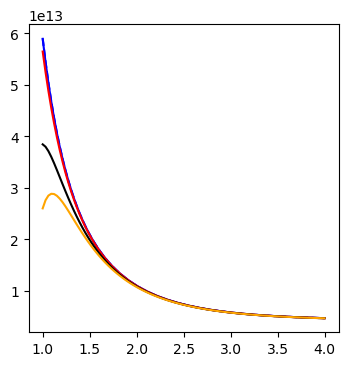

In [118]:
# r = 40 nm
#E_0_fixed = 0.0001
#d_ii_2 = [0.0, 10, 50, 150, 200]
#J_factor06, E06, omega_np06, omega06 = rabi_frequency(x_points = x_arr2, y = y_arr[0], z = 1e-15, dperm = \
#                                                      d_ii_2[1], refr_ind = m_silver, lam_list = ref_lam_silver, 
#                                                      r = r2, n = 1, lam_value = lam2, E_0 = E_0_fixed)
#J_factor16, E16, omega_np16, omega16 = rabi_frequency(x_points = x_arr2, y = y_arr[0], z = 1e-15, dperm = \
#                                                      d_ii_2[2], refr_ind = m_silver, lam_list = ref_lam_silver, 
#                                                      r = r2, n = 1, lam_value = lam2, E_0 = E_0_fixed)
#J_factor26, E26, omega_np26, omega26 = rabi_frequency(x_points = x_arr2, y = y_arr[0], z = 1e-15, dperm = \
#                                                      d_ii_2[3], refr_ind = m_silver, lam_list = ref_lam_silver, 
#                                                      r = r2, n = 1, lam_value = lam2, E_0 = E_0_fixed)
#J_factor36, E36, omega_np36, omega36 = rabi_frequency(x_points = x_arr2, y = y_arr[0], z = 1e-15, dperm = \
#                                                      d_ii_2[4], refr_ind = m_silver, lam_list = ref_lam_silver, 
#                                                      r = r2, n = 1, lam_value = lam2, E_0 = E_0_fixed)
#omega6 = [omega_np06, omega06, omega16, omega26, omega36]
#print(omega36)
#fig, ax = plt.subplots(1,1,figsize = (4,4))
#lss = ['--', 'solid', 'solid', 'solid', 'solid']
#col2 = ['blue', 'blue', 'red', 'black', 'orange']
#for q in range(5):
#    ax.plot(r_arr2/(r2*1e3), omega6[q], label = f'd = {d_ii_2[q]}', color = col2[q], ls = lss[q])
#ind = np.where(omega36 == np.max(omega36))
#print(ind[0])
#print(r_arr2[np.where(omega36 == np.max(omega36))])

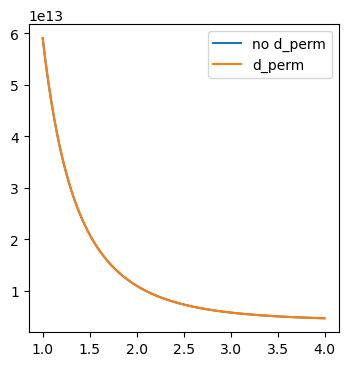

In [148]:
#fig, ax = plt.subplots(1,1,figsize = (4,4))
#ax.plot(r_arr2/(r2*1e3),omega_np01,label='no d_perm')
#ax.plot(r_arr2/(r2*1e3),omega01,label='d_perm')
#ax.legend()

Omegas [0.]


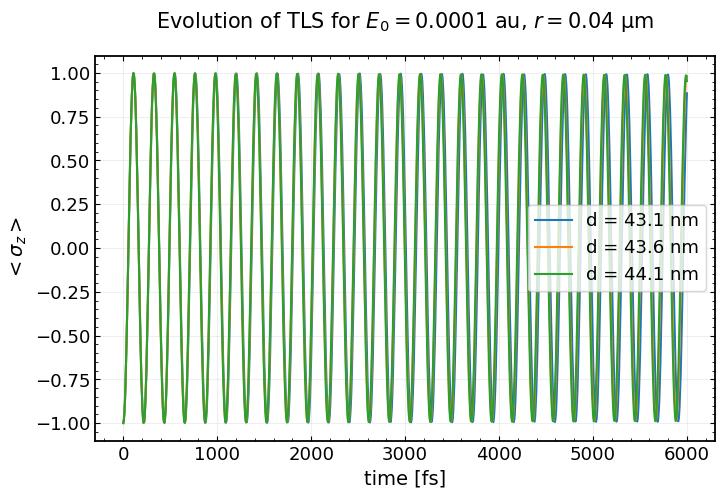

In [146]:
#qutip_integration(m_silver, ref_lam_silver, x_points = np.array([43.1, 43.6, 44.1]), 
#                  d_perm = 200.0, E_0 = 0.0001, r = r2, lam_val = 0.38, tf = 60e-13, transformed_H = False)

Omegas [2.87192339e+13 2.88154734e+13 2.88427010e+13]
Omega 28719.233887817467 Delta 41.597905960000006 Gamma 206306436.82662675
Omega 28815.47344169923 Delta 41.877168076000004 Gamma 265745091.6201513
Omega 28842.700963867595 Delta 41.956344802000004 Gamma 329795717.57107115


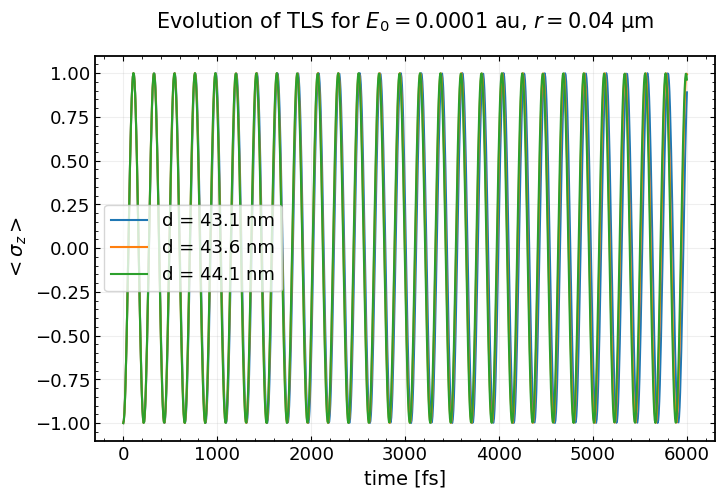

In [139]:
#qutip_integration(m_silver, ref_lam_silver, x_points = np.array([43.1, 43.6, 44.1]), 
#                  d_perm = 200.0, E_0 = 0.0001, r = r2, lam_val = 0.38, tf = 60e-13, transformed_H = True)

Omegas [4.83719514e+13 4.69209256e+13 4.55325415e+13]
Omega 48371.95142702759 Delta 118.009781062 Gamma 3253251233.353857
Omega 46920.92564231538 Delta 111.03591417000001 Gamma 3253251233.353857
Omega 45532.54147428746 Delta 104.561953508 Gamma 3253251233.353857


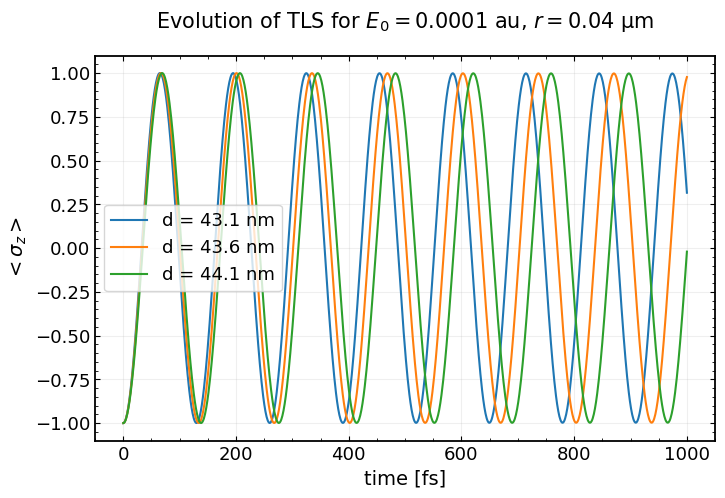

In [145]:
#qutip_integration(m_silver, ref_lam_silver, x_points = np.array([43.1, 43.6, 44.1]), 
#                  d_perm = 0.0, E_0 = 0.0001, r = r2, lam_val = 0.38, tf = 10e-13, transformed_H = True)

In [121]:
def qutip_integration(m, lam_vals, d_tr = 1, d_perm = 1.0, r = 0.04, x_points = np.array([40.5*(10**-9)]), \
                      tf = 10e-15, numtimes = 1000, E_0 = 0.0001, lam_val = 0.36, om_eg = None, 
                      transformed_H = False, savefig = True):
    
    """ Estimates the expectation value of the sigma_z operator for a TLS initially in the ground state that is 
        positioned in the vicinity of a spherical nanoparticle and is exposed to the field enhanced by the nanosphere.
        Plots the evolution of the system over a time period TF.
        
        Inputs:  m [float]: list of refractive indices for corresponding wavelengths lam_vals. 
                 M must be of the form real(m) + 1j*imag(m) [unitless]
                 lam_vals [float]: wavelengths corresponding to REF_IND [μm]
                 d_tr [float]: transition dipole moment of the TLS [au]
                 d_perm [float]: permanent dipole moment of the TLS [au]
                 r [float]: radius of the nanosphere [μm]
                 x_points [float]: array of positions of the TLS [nm]
                 tf [float]: final time for the evolution [s]
                 numtimes [int]: number of time steps at which <sigma_z> is evaluated
                 E_0 [float]: incident field intensity [au]
                 lam_val [float]: lam_value [float]: wavelength of incident plane wave (must belong to LAM_LIST) [μm]
                 om_eg [float]: transition frequency of the TLS [au]. Must be specified if system is not at
                 resonance with the incident light
                 transformed_H [bool]: if True, the approximated Hamiltonian in the rotated frame is used. If False, 
                                       the full Hamiltonian is used.
                 savefig [bool]: if True, plot saved under the name 'evolution.jpg' """
    
    g = qp.basis(2, 1)
    rho0 = g * g.dag() # Initially in ground state
    sig_z = qp.sigmaz()
    sig_x = qp.sigmax()
    sig_p = qp.sigmap()
    sig_m = qp.sigmam()
    eye = qp.qeye(2)
    E_0val = E_0 * 5.14220675112e11
    omega_pr_vals, delta_pr_vals, gamma_pr_vals, gamma_vals, g_x_vals, g_I_vals, g_z_vals, w_c, w_eg = \
    constants(ref_ind = m, lam_list = lam_vals, lam_val = lam_val, E_0 = E_0, r = r, d_tr = d_tr, d_perm = d_perm, \
              om_eg = om_eg, x_points = x_points, order = 1, plot = False, transformed_H = transformed_H)
    times = np.linspace(0.0, tf, numtimes)
    print('Omegas', omega_pr_vals)
    fig, ax = plt.subplots(1,1, figsize = (8,5))
    ax.set_xlabel('time [fs]', fontsize=14)
    ax.set_ylabel('$<\sigma_z>$', fontsize=14)
    ax.minorticks_on()
    ax.tick_params(axis="both", direction="in", which="both", right=True, top=True, labelsize=13)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.3)
    ax.grid(alpha = 0.2)
    
    for i in range(len(gamma_vals)):
        gamma = gamma_vals[i]
        g_x = g_x_vals[i]
        g_I = g_I_vals[i]
        g_z = g_z_vals[i]
        def H1_coeff(t,args):
            return 0.5*w_eg*sig_z + (0.5*g_z*sig_z + g_x*(sig_p + sig_m))*np.cos(w_c*t)
    
        if transformed_H:
            omega_pr = omega_pr_vals[i]
            delta_pr = delta_pr_vals[i]
            gamma_pr = gamma_pr_vals[i]
            H = -0.5*delta_pr*sig_z + 0.5*omega_pr*sig_x
            print('Omega', omega_pr*1e-9, 'Delta', delta_pr*1e-9, 'Gamma', gamma_pr)
            result = qp.mesolve(H, rho0, times, [np.sqrt(gamma_pr) * qp.sigmap()], e_ops=[qp.sigmaz()])     
        else:
            result = qp.mesolve(H1_coeff, rho0, times, [np.sqrt(gamma) * qp.sigmap()], e_ops=[qp.sigmaz()])
                
        ax.plot(times*1e15, result.expect[0], label = f'd = {x_points[i]:.1f} nm')

    ax.legend(fontsize=13)
    ax.set_title(f'Evolution of TLS for $E_0 = {E_0}$ au, $r = {r}$ μm', fontsize=15, wrap = True, pad = 20)
    if savefig:
        plt.savefig(fname = 'evolution.jpg', format = 'jpg')
    plt.show()
    return

### Stylistic: standard plotting style

In [17]:
def general_plot_style(x, y, legendlabels = None, colors = None, ls = None, figsize = [9,9], ylims = None, \
                       subplots = [1,1], xlabel = None, ylabel = None, title = None, filename = 'default.jpg', \
                       savefig = False):
    
    """ Generates a standardised plot of X vs Y with ticks on all 4 axes. Plot may either contain SUBPLOTS with one
        data series plotted on each subplot or it may contain a single subplot with all data series plotted there.
        
        Inputs: x [float]: array of x values/arrays of x values
                y [float]: array of y values/arrays of y values. Must have the same shape as X.
                legendlabels [sting]: array of labels for all data series in y 
                colors [string]: array of colors for all data series in y 
                ls [string]: array of linestyles for all data series in y
                figsize [float]: list of two values detailing the x and y dimensions of the plots
                ylims [float/None]: if specified, y_axis is truncated at YLIMS. In particular, this fucntionality
                is useful for decay rate plots
                subplots [float]: list of two values detailing the number of subplots of the plot. Default is single
                subplot
                xlabel [string]: label for the x-axes of all subplots
                ylabel [string]: label for the y-axes of all subplots
                title [string]: suptitle of the plot
                filename [string]: name under which plot is saved if SAVEFIG. Must contain the quotation marks
                savefig [bool]: if True, figure saved under name filename """
    
    fig, ax = plt.subplots(subplots[0],subplots[1], figsize = (figsize[0], figsize[1]))
    
    if subplots[0] == 1 and subplots[1] == 1:
        for ind in range(len(x)):
            ax.plot(x[ind], y[ind], label = legendlabels[ind], color = colors[ind], ls = ls[ind])
        #ax.plot(x, y, label = legendlabels[0], color = colors[0], ls = ls[0])

        ax.set_xlabel(xlabel, fontsize=14)
        ax.set_ylabel(ylabel, fontsize=14)
        if ylims != None:
            ax.set_ylim(ylims[0], ylims[1])
        ax.minorticks_on()
        ax.tick_params(axis="both", direction="in", which="both", right=True, top=True, labelsize=13)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(1.3)
        ax.grid(alpha = 0.2)
        ax.legend(fontsize=13)

        ax.set_title(title, fontsize=15, wrap = True, pad = 25)
        return
    elif subplots[0] == 1:
        for i in range(subplots[1]):
            ax[i].plot(x[i], y[i], label = legendlabels[i], color = colors[i], ls = ls[i])
            ax[i].set_xlabel(xlabel, fontsize=14)
            ax[i].set_ylabel(ylabel, fontsize=14)
            if ylims != None:
                ax[i].set_ylim(ylims[0], ylims[1])
            ax[i].minorticks_on()
            ax[i].tick_params(axis="both", direction="in", which="both", right=True, top=True, labelsize=13)
            for axis in ['top','bottom','left','right']:
                ax[i].spines[axis].set_linewidth(1.3)
            ax[i].grid(alpha = 0.2)
            ax[i].legend(fontsize=13)    
        
    elif subplots[1] == 1:
        for i in range(subplots[0]):
            ax[i].plot(x[i], y[i], label = legendlabels[i], color = colors[i], ls = ls[i])
            ax[i].set_xlabel(xlabel, fontsize=14)
            ax[i].set_ylabel(ylabel, fontsize=14)
            if ylims != None:
                ax[i].set_ylim(ylims[0], ylims[1])
            ax[i].minorticks_on()
            ax[i].tick_params(axis="both", direction="in", which="both", right=True, top=True, labelsize=13)
            for axis in ['top','bottom','left','right']:
                ax[i].spines[axis].set_linewidth(1.3)
            ax[i].grid(alpha = 0.2)
            ax[i].legend(fontsize=13)  
        
    else:
        for j in range(subplots[0]):
            for i in range(subplots[1]):
                ax[j,i].plot(x[i+j], y[i+j], label = legendlabels[i+j], color = colors[i+j], ls = ls[i+j])
                ax[j,i].set_xlabel(xlabel, fontsize=14)
                ax[j,i].set_ylabel(ylabel, fontsize=14)
                if ylims != None:
                    ax[j,i].set_ylim(ylims[0], ylims[1])
                ax[j,i].minorticks_on()
                ax[j,i].tick_params(axis="both", direction="in", which="both", right=True, top=True, labelsize=13)
                for axis in ['top','bottom','left','right']:
                    ax[j,i].spines[axis].set_linewidth(1.3)
                ax[j,i].grid(alpha = 0.2)
                ax[j,i].legend(fontsize=13)

    plt.tight_layout(pad = 3)
    plt.suptitle(title, fontsize=15, wrap = True)        
    if savefig:
        plt.savefig(fname = filename, format = 'jpg')
    plt.show()
    return